# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
# train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
# val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
batch_size = 4

train_doc = np.random.permutation(open('/home/asr563up/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/asr563up/Project_data/val.csv').readlines())

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

Following new parameters were added to generator function to experiment with more parameters
1. ablation -> experiment with smaller dataset and try to overfit on it 
2. batch_size -> an ideal batch_size can help us train the network better and faster
3. image_frames_to_retain -> number of video frames to consider
4. image_shape -> defaults to (100,100)

In [4]:
def generator(source_path, folder_list, batch_size=batch_size, 
              ablation=-1, image_frames_to_retain=9, 
              image_shape=(100, 100)):
    
    img_idx = list(range(1, min(image_frames_to_retain+1, 31)))
    x = len(img_idx)
    width = image_shape[0]
    height = image_shape[1]
    
    # code for ablation
    if ablation != -1:
        
        folder_list_temp = [] 
        
        labels = [0, 1, 2, 3, 4]
        
        for label in labels:
            
            folder_list_label = []
            
            searchText = re.compile('.*'+ str(label) + '\\n')
            
            folder_list_label = list(filter(searchText.match, folder_list))
            
            folder_list_label = folder_list_label[0: min(ablation, len(folder_list_label))]
            
            folder_list_temp = folder_list_temp + folder_list_label
            
        folder_list = folder_list_temp
 
        
    
    while True:
        
        
        
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        
#         for batch in range(0):
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, x, height, width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    if image.shape[1]/image.shape[0] == 1:
                        
                        # image   has been brought to 224 * 224 res
                        image = imresize(image, (height, width))
                        
                    else:
                        
                        image = image[:, 20:140, :]
                        image = imresize(image, (height, width))
                        
                    
#                     img_reshaped_quantile = np.quantile(image.reshape(-1, 3), [0.05, 0.95], axis=1)
                    
                    batch_data[folder,idx,:,:,0] = image[:, :, 0]/255
                    batch_data[folder,idx,:,:,1] = image[:, :, 1]/255
                    batch_data[folder,idx,:,:,2] = image[:, :, 2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        remaining_data_points = len(folder_list) - num_batches * batch_size
        
        # rerunning the generator for new epoch
        if remaining_data_points == 0:
            continue
        
        batch_data = np.zeros((remaining_data_points, x, height, width, 3))
        batch_labels = np.zeros((remaining_data_points,5))
        
        for folder in range(num_batches * batch_size, len(folder_list)):
            imgs = os.listdir(source_path+'/'+ t[folder].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes
                if image.shape[1]/image.shape[0] == 1:
                        
                    # image   has been brought to 224 * 224 res
                    image = imresize(image, (height, width))
                        
                else:
                        
                    image = image[:, 20:140, :]
                    image = imresize(image, (height, width))
                    
                    
                
                    
                batch_data[folder - num_batches * batch_size ,idx,:,:,0] = image[:, :, 0]/255
                batch_data[folder - num_batches * batch_size,idx,:,:,1] = image[:, :, 1]/255
                batch_data[folder- num_batches * batch_size,idx,:,:,2] = image[:, :, 2]/255
                
            batch_labels[folder - num_batches * batch_size, int(t[folder].strip().split(';')[2])] = 1
        
        yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'
train_path = '/home/asr563up/Project_data/train'
val_path = '/home/asr563up/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 2
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 2


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, GlobalMaxPool2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.metrics import AUC, Precision, Recall
from keras.callbacks import Callback

#write your model here

### TimeDistributed Conv2D + RNN(GRU) Modelm

In [7]:
# VGG16 inspired network , we will be adding breaks in between to limit network at specific length . 
def extract_layers_from_vgg16(layers=5, image_frames_to_retain=9, image_shape=(100, 100), **kwargs):
    model = Sequential()
    
    model.add(
        TimeDistributed(
            Conv2D(
            filters=64,
            kernel_size=(3, 3),
            padding="same",
            activation="relu"),
            input_shape=(image_frames_to_retain, image_shape[1], image_shape[0], 3)
        )
    )
    
    model.add(
        TimeDistributed(
            Conv2D(
            filters=64,
            kernel_size=(3, 3),
            padding="same",
            activation="relu"),
        )
    )
    


    model.add(
        TimeDistributed(
        MaxPooling2D(pool_size=(2,2),strides=(2,2))
        )
    )

    model.add(
        TimeDistributed(
            BatchNormalization()
        )
    )
    
    if layers == 1:
        return model


    model.add(
        TimeDistributed(
            Conv2D(
            filters=128,
            kernel_size=(3, 3),
            padding="same",
            activation="relu"),
        )
    )

    model.add(
        TimeDistributed(
            Conv2D(
            filters=128,
            kernel_size=(3, 3),
            padding="same",
            activation="relu"),
        )
    )

    model.add(
        TimeDistributed(
        MaxPooling2D(pool_size=(2,2),strides=(2,2))
        )
    )

    model.add(
        TimeDistributed(
            BatchNormalization()
        )
    )
    
    if layers == 2:
        return model

    model.add(
        TimeDistributed(
            Conv2D(
            filters=256,
            kernel_size=(3, 3),
            padding="same",
            activation="relu"),
        )
    )

    model.add(
        TimeDistributed(
            Conv2D(
            filters=256,
            kernel_size=(3, 3),
            padding="same",
            activation="relu"),
        )
    )

    model.add(
        TimeDistributed(
            Conv2D(
            filters=256,
            kernel_size=(3, 3),
            padding="same",
            activation="relu"),
        )
    )


    model.add(
        TimeDistributed(
        MaxPooling2D(pool_size=(2,2),strides=(2,2))
        )
    )

    model.add(
        TimeDistributed(
            BatchNormalization()
        )
    )
    
    if layers == 3:
        return model

    model.add(
        TimeDistributed(
            Conv2D(
            filters=512,
            kernel_size=(3, 3),
            padding="same",
            activation="relu"),
        )
    )

    model.add(
        TimeDistributed(
            Conv2D(
            filters=512,
            kernel_size=(3, 3),
            padding="same",
            activation="relu"),
        )
    )

    model.add(
        TimeDistributed(
            Conv2D(
            filters=512,
            kernel_size=(3, 3),
            padding="same",
            activation="relu"),
        )
    )

    model.add(
        TimeDistributed(
        MaxPooling2D(pool_size=(2,2),strides=(2,2))
        )
    )
    
    if layers == 4:
        return model

    model.add(
        TimeDistributed(
            Conv2D(
            filters=512,
            kernel_size=(3, 3),
            padding="same",
            activation="relu"),
        )
    )

    model.add(
        TimeDistributed(
            Conv2D(
            filters=512,
            kernel_size=(3, 3),
            padding="same",
            activation="relu"),
        )
    )

    model.add(
        TimeDistributed(
            Conv2D(
            filters=512,
            kernel_size=(3, 3),
            padding="same",
            activation="relu"),
        )
    )

    model.add(
        TimeDistributed(
        MaxPooling2D(pool_size=(2,2),strides=(2,2))
        )
    )
    
    if layers == 5:
        return model
    
    return model


def conv2d_rnn(layers=13, after_flatten_layer_size=3, after_flatten_layer_jump=2, 
               image_frames_to_retain=9, image_shape=(100, 100), **kwargs):
    
    model = extract_layers_from_vgg16(layers=layers, image_frames_to_retain=image_frames_to_retain,
                                      image_shape=image_shape)
    
    model.add(
    TimeDistributed(
        Flatten())
    )

    
    model.add(
    GRU(30)
    )
    
    for layer in range(after_flatten_layer_size, 1, -1):
        
        unit_size = 5 * ((after_flatten_layer_jump) ** (layer-1))
        model.add(Dense(unit_size, activation='relu'))
        
    
    model.add(Dense(5, activation='softmax'))
    
    return model
    


### Conv3d Model

In [8]:
def conv3D_model_core_layers(layers=5, initial_filter_size=32, 
                             filter_jump=2, jump_mode="*",
                            image_frames_to_retain=9, image_shape=(100, 100)):
    
    model = Sequential()
    
    filter_size = initial_filter_size
    
    for layer in range(0, layers):
        
        model.add(
            Conv3D(
                filters=filter_size,
                kernel_size=(2, 2, 2),
                padding="same",
                activation="relu",
                input_shape=(image_frames_to_retain, image_shape[1], image_shape[0], 3)
            )
        )
        
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        if jump_mode == '*':
            
        
            filter_size = filter_size * 2
            
    return model
        
        

def conv3d_model(layers=3, 
                 initial_filter_size=32, 
                 filter_jump=2, 
                 jump_mode="*", 
                 after_flatten_layer_size=3,
                 after_flatten_layer_jump=2, image_frames_to_retain=9, image_shape=(100, 100)):
    
    model = conv3D_model_core_layers(layers=layers, initial_filter_size=initial_filter_size, 
                                     filter_jump=filter_jump, jump_mode=jump_mode,
                                     image_frames_to_retain=image_frames_to_retain, image_shape=image_shape
                                    )
    
    model.add(
        Flatten()
    )
    
    for layer in range(after_flatten_layer_size, 1, -1):
        
        unit_size = 5 * ((after_flatten_layer_jump) ** (layer-1))
        model.add(Dense(unit_size, activation='relu'))
        
    
    model.add(Dense(5, activation='softmax'))
    
    return model

### Model Compilation

In [17]:
# model = conv2d_rnn(layers=2)
# optimiser = optimizers.Adam()
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy', AUC()])
# print (model.summary())

global_storage = []

class ComputeMetrics(Callback):
    
    def __init__(self, storage, model_name, ablation, layer, 
                 initial_filter_size, filter_jump, 
                 jump_mode, after_flatten_layer_size, after_flatten_layer_jump, 
                 image_frames_to_retain, image_shape,
                 *args, **kwargs):
        
        self.storage = storage
        self.storage.append({})
        self.storage[-1]['model_name'] = model_name
        self.storage[-1]['ablation'] = ablation
        self.storage[-1]['layer'] = layer
        self.storage[-1]['initial_filter_size'] = initial_filter_size
        self.storage[-1]['filter_jump'] = filter_jump
        self.storage[-1]['jump_mode'] = jump_mode
        self.storage[-1]['after_flatten_layer_size'] = after_flatten_layer_size
        self.storage[-1]['after_flatten_layer_jump'] = after_flatten_layer_jump
        self.storage[-1]['image_frames_to_retain'] = image_frames_to_retain
        self.storage[-1]['image_shape'] = image_shape
        
        
        super().__init__(*args, **kwargs);
    
    def on_epoch_end(self, epoch, logs):
        temp_storage = logs
        temp_storage['epoch'] = epoch
        self.storage[-1].update(temp_storage)

        
def test_model(model, 
               layers=[1, 2, 3, 4, 5, 6], 
                ablations=[-1], 
                initial_filter_sizes=[32, 42], 
                filter_jumps=[2, 3], 
                after_flatten_layer_sizes=[3, 4],
                after_flatten_layer_jumps=[2, 3], 
                image_frames_to_retain=[9], 
                image_shapes=[(100,100)]
                ):

    
    for ablation in ablations:
        if (num_train_sequences%batch_size) == 0 and ablation == -1:
            steps_per_epoch = int(num_train_sequences/batch_size)
        elif ablation == -1:
            steps_per_epoch = (num_train_sequences//batch_size) + 1 
        elif ((ablation * 5)%batch_size) == 0 and ablation != -1:
            steps_per_epoch = int(ablation * 5/batch_size)
        else:
            steps_per_epoch = int(ablation * 5//batch_size)
    

        if (num_val_sequences%batch_size) == 0 and ablation == -1:
            validation_steps = int(num_val_sequences/batch_size)
        elif ablation == -1:
            validation_steps = (num_val_sequences//batch_size) + 1
        elif ((ablation * 5)%batch_size) == 0 and ablation != -1:
            validation_steps = int(ablation * 5/batch_size)
        else:
            validation_steps = int(ablation * 5//batch_size)
            
        
        
        
        for layer in layers:
            
            for filter_size in initial_filter_sizes:
                
                for filter_jump in filter_jumps:
                    
                    for after_flatten_layer_size in after_flatten_layer_sizes:
                        
                        for after_flatten_layer_jump in after_flatten_layer_jumps:
                            
                            for image_frames_to_retain_val in image_frames_to_retain:                                
                                
                                for image_shape in image_shapes:
                                    
                                    
                                    train_generator = generator(train_path, train_doc, batch_size, 
                                                                ablation=ablation, image_frames_to_retain=image_frames_to_retain_val, 
                                                                image_shape=image_shape)
                                    val_generator = generator(val_path, val_doc, batch_size, 
                                                              ablation=ablation, image_frames_to_retain=image_frames_to_retain_val, 
                                                                image_shape=image_shape )
                                    
                                    
                                    
                                    print(layer,
                                        filter_size, 
                                        filter_jump,
                                        after_flatten_layer_size,
                                        after_flatten_layer_jump,
                                        image_frames_to_retain_val, image_shape)

                                    try:
                                        __model__ = model(
                                            layers=layer,
                                            initial_filter_size=filter_size, 
                                            filter_jump=filter_jump, 
                                            jump_mode="*", 
                                            after_flatten_layer_size=after_flatten_layer_size,
                                            after_flatten_layer_jump=after_flatten_layer_jump,
                                            image_frames_to_retain=image_frames_to_retain_val, image_shape=image_shape
                                            )
                                    except Exception as err:
                                        print(err)
                                        # model cannot be created
                                        continue
                                        
                                    

                                    __model__.compile(optimizer=optimizers.SGD(), loss='categorical_crossentropy', 
                                      metrics=['categorical_accuracy', AUC()])
                                    
#                                     print(__model__.summary())
                                    
#                                     continue
                                
                                    

    #             print(ablation)
                                    __model__.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                                 class_weight=None, workers=1, initial_epoch=0, 
                                                validation_data=val_generator, 
                                                validation_steps=validation_steps,
                                                use_multiprocessing=False, callbacks=[ComputeMetrics(
                                                    storage=global_storage,
                                                    model_name='temp',
                                                    ablation=ablation,
                                                    layer=layer, 
                                                    initial_filter_size=filter_size, 
                                                    filter_jump=filter_jump, 
                                                    jump_mode="*", 
                                                    after_flatten_layer_size=after_flatten_layer_size,
                                                    after_flatten_layer_jump=after_flatten_layer_jump,
                                                    image_frames_to_retain=image_frames_to_retain_val, image_shape=image_shape
                                                )])
  

### Running Analysis on various hyperparameters for Conv2d + GRU model

Following are the hyperparameters of our learning alogrithm (it;s a function that helps us guess the ideal layer and parameter qunatity)
1. layers -> [3, 4]
4. after_flatten_layer_sizes=[2, 3],
5. after_flatten_layer_jumps=[2, 3],
6. image_frames_to_retain=[16],
7. image_shapes=[(40, 40)]

In [ ]:
num_epochs = 2
global_storage = []
test_model(conv2d_rnn, layers=[3, 4],  after_flatten_layer_sizes=[2, 3],
           after_flatten_layer_jumps=[2, 3],
           image_frames_to_retain=[16], image_shapes=[(40, 40)])

In [14]:
# sns.lineplot(data=df, x='layers', y='categorical_accuracy', hue='name')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# df = pd.DataFrame.from_dict(global_storage).sort_values('val_categorical_accuracy', axis=0, ascending=False)
# df.to_csv('file1.csv')
result = []

for res in global_storage:
    keys = list(res.keys())
    search_auc_reg = re.compile('^auc_.*$')            
    search_auc_key = list(filter(search_auc_reg.match, keys))
    
    search_auc_val_reg = re.compile('^.+auc_.*$')            
    search_auc_val_key = list(filter(search_auc_val_reg.match, keys))
    res['auc'] = res[search_auc_key[0]]
    res['val_auc'] = res[search_auc_val_key[0]]
    

    
df = pd.DataFrame.from_dict(global_storage).sort_values('val_auc', axis=0, ascending=False)


df_all_layer = df.loc[:,['filter_jump',
                                        'layer', 'val_categorical_accuracy',
                                       'categorical_accuracy', 'auc', 'val_auc']]
display(df_all_layer)

,filter_jump,layer,val_categorical_accuracy,categorical_accuracy,auc,val_auc
5,3,3,0.46,0.423831,0.767191,0.765575
7,3,3,0.32,0.437406,0.768357,0.629250
0,2,3,0.26,0.398190,0.724709,0.624475
11,2,3,0.35,0.467572,0.788141,0.615713
9,2,3,0.27,0.420814,0.769678,0.593825
4,3,3,0.24,0.458522,0.775966,0.575350
8,2,3,0.27,0.432881,0.771163,0.557413
1,2,3,0.21,0.413273,0.743951,0.557087
10,2,3,0.25,0.447964,0.755079,0.547963
6,3,3,0.21,0.413273,0.770630,0.534975


### Running Analysis on various hyperparameters for Conv3d model

Following are the hyperparameters of our learning alogrithm (it;s a function that helps us guess the ideal layer and parameter qunatity)
1. layers -> [3, 4]
2. initial_filter_sizes -> [30, 60]
3. filter_jumps -> [2, 3]
4. after_flatten_layer_sizes=[3, 4],
5. after_flatten_layer_jumps=[2, 3],
6. image_frames_to_retain=[16],
7. image_shapes=[(40, 40)]

In [80]:
# test_model(conv3d_model, layers=[4], 
#            initial_filter_sizes=[30], 
#            filter_jumps=[2], after_flatten_layer_sizes=[3],
#            after_flatten_layer_jumps=[2],
#            image_frames_to_retain=[16], image_shapes=[(40, 40)])
global_storage = []
test_model(conv3d_model, layers=[3, 4], 
           initial_filter_sizes=[30, 60], 
           filter_jumps=[2, 3], after_flatten_layer_sizes=[3],
           after_flatten_layer_jumps=[2],
           image_frames_to_retain=[16], image_shapes=[(40, 40)])

3 30 2 3 2 16 (40, 40)
Epoch 1/2
166/166 [==============================] - 119s 718ms/step - loss: 1.7095 - categorical_accuracy: 0.2428 - auc_130: 0.5478 - val_loss: 2.3375 - val_categorical_accuracy: 0.2000 - val_auc_130: 0.5298
Epoch 2/2
166/166 [==============================] - 115s 693ms/step - loss: 1.5009 - categorical_accuracy: 0.3454 - auc_130: 0.6535 - val_loss: 2.2010 - val_categorical_accuracy: 0.2900 - val_auc_130: 0.6153
3 30 3 3 2 16 (40, 40)
Epoch 1/2
166/166 [==============================] - 120s 724ms/step - loss: 1.7398 - categorical_accuracy: 0.1931 - auc_131: 0.5059 - val_loss: 0.9105 - val_categorical_accuracy: 0.2400 - val_auc_131: 0.5566
Epoch 2/2
166/166 [==============================] - 115s 694ms/step - loss: 1.6062 - categorical_accuracy: 0.1840 - auc_131: 0.5093 - val_loss: 1.5339 - val_categorical_accuracy: 0.1700 - val_auc_131: 0.5638
3 60 2 3 2 16 (40, 40)
Epoch 1/2
166/166 [==============================] - 212s 1s/step - loss: 1.6596 - categorical_

In [112]:
# sns.lineplot(data=pd.from_dict())
# df = pd.DataFrame.from_dict(global_storage)
# sns.lineplot(data=df, x='layers', y='categorical_accuracy', hue='name')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# df = pd.DataFrame.from_dict(global_storage).sort_values('val_categorical_accuracy', axis=0, ascending=False)
# df.to_csv('file1.csv')
result = []

for res in global_storage:
    keys = list(res.keys())
    search_auc_reg = re.compile('^auc_.*$')            
    search_auc_key = list(filter(search_auc_reg.match, keys))
    
    search_auc_val_reg = re.compile('^.+auc_.*$')            
    search_auc_val_key = list(filter(search_auc_val_reg.match, keys))
    res['auc'] = res[search_auc_key[0]]
    res['val_auc'] = res[search_auc_val_key[0]]
    

    
df = pd.DataFrame.from_dict(global_storage).sort_values('val_auc', axis=0, ascending=False)


df_all_layer = df.loc[:,['initial_filter_size', 'filter_jump',
                                        'layer', 'val_categorical_accuracy',
                                       'categorical_accuracy', 'auc', 'val_auc']]

,initial_filter_size,filter_jump,layer,val_categorical_accuracy,categorical_accuracy,auc,val_auc
3,60,2,3,0.25,0.196078,0.494113,0.623388
1,30,2,3,0.29,0.345400,0.653538,0.615312
5,30,2,4,0.28,0.309201,0.649221,0.599238
7,60,2,4,0.24,0.387632,0.755966,0.583625
6,30,3,4,0.22,0.386124,0.747090,0.565687
2,30,3,3,0.17,0.184012,0.509326,0.563800
4,60,3,3,0.23,0.179487,0.500982,0.528100
0,30,2,3,0.22,0.206637,0.494496,0.518750
8,60,3,4,0.19,0.262443,0.567326,0.515438


Above table shows that model 1 with `30 initial filter` size , `3 conv3d layers` outperforms other model in terms of `val_auc` and `val_categorcial_accuracy`

Taking model 1 as base model , we will try to tune it further for higher accuracy

1. Ideation 1: Iterating over final dense layers , image size and total number of video frames 

In [124]:
global_storage = []
num_epochs = 3
test_model(conv3d_model, layers=[3], 
           initial_filter_sizes=[30], 
           filter_jumps=[2], after_flatten_layer_sizes=[2, 3],
           after_flatten_layer_jumps=[2, 3],
           image_frames_to_retain=[16, 20], image_shapes=[(40, 40), (60, 60)])

3 30 2 2 2 16 (40, 40)
3 30 2 2 2 16 (60, 60)
3 30 2 2 2 20 (40, 40)
3 30 2 2 2 20 (60, 60)
3 30 2 2 3 16 (40, 40)
3 30 2 2 3 16 (60, 60)
3 30 2 2 3 20 (40, 40)
3 30 2 2 3 20 (60, 60)
3 30 2 3 2 16 (40, 40)
3 30 2 3 2 16 (60, 60)
3 30 2 3 2 20 (40, 40)
3 30 2 3 2 20 (60, 60)
3 30 2 3 3 16 (40, 40)
3 30 2 3 3 16 (60, 60)
3 30 2 3 3 20 (40, 40)
3 30 2 3 3 20 (60, 60)


In [131]:
result = []

for res in global_storage:
    keys = list(res.keys())
    search_auc_reg = re.compile('^auc_.*$')            
    search_auc_key = list(filter(search_auc_reg.match, keys))
    
    search_auc_val_reg = re.compile('^.+auc_.*$')            
    search_auc_val_key = list(filter(search_auc_val_reg.match, keys))
    res['auc'] = res[search_auc_key[0]]
    res['val_auc'] = res[search_auc_val_key[0]]
    

    
df = pd.DataFrame.from_dict(global_storage).sort_values('val_auc', axis=0, ascending=False)


df_all_layer = df.loc[:,['after_flatten_layer_size', 'after_flatten_layer_jump',
                                        'image_frames_to_retain', 'image_shape', 'val_categorical_accuracy',
                                       'categorical_accuracy', 'auc', 'val_auc']]

display(df_all_layer)

,after_flatten_layer_size,after_flatten_layer_jump,image_frames_to_retain,image_shape,val_categorical_accuracy,categorical_accuracy,auc,val_auc
14,3,3,20,"(40, 40)",0.53,0.514329,0.846451,0.861413
11,3,2,20,"(60, 60)",0.49,0.475113,0.820293,0.833387
9,3,2,16,"(60, 60)",0.53,0.432881,0.751547,0.828625
8,3,2,16,"(40, 40)",0.53,0.453997,0.810648,0.825137
13,3,3,16,"(60, 60)",0.24,0.434389,0.802486,0.679350
7,2,3,20,"(60, 60)",0.34,0.358974,0.703632,0.650863
3,2,2,20,"(60, 60)",0.31,0.226244,0.547674,0.599325
15,3,3,20,"(60, 60)",0.25,0.218703,0.532682,0.558313
1,2,2,16,"(60, 60)",0.23,0.208145,0.514927,0.547850
10,3,2,20,"(40, 40)",0.20,0.196078,0.506582,0.546937


Model with after flatten layer size -> 3 , layer jump 3 , image frames to retain 20 and image shape (40, 40) outperforms other model with the availablle data . 

In [ ]:
global_storage = []
num_epochs = 11
batch_size = 4
test_model(conv3d_model, layers=[3, 4], 
           initial_filter_sizes=[30], 
           filter_jumps=[2], after_flatten_layer_sizes=[3],
           after_flatten_layer_jumps=[3],
           image_frames_to_retain=[20], image_shapes=[(40, 40)])

In [147]:
result = []

for res in global_storage:
    keys = list(res.keys())
    search_auc_reg = re.compile('^auc_.*$')            
    search_auc_key = list(filter(search_auc_reg.match, keys))
    
    search_auc_val_reg = re.compile('^.+auc_.*$')            
    search_auc_val_key = list(filter(search_auc_val_reg.match, keys))
    res['auc'] = res[search_auc_key[0]]
    res['val_auc'] = res[search_auc_val_key[0]]
    

    
df = pd.DataFrame.from_dict(global_storage).sort_values('val_auc', axis=0, ascending=False)


df_all_layer = df.loc[:,['after_flatten_layer_size', 'after_flatten_layer_jump',
                                        'image_frames_to_retain', 'image_shape', 'val_categorical_accuracy',
                                       'categorical_accuracy', 'auc', 'val_auc', 'layer']]

display(df_all_layer)

,after_flatten_layer_size,after_flatten_layer_jump,image_frames_to_retain,image_shape,val_categorical_accuracy,categorical_accuracy,auc,val_auc,layer
1,3,3,20,"(40, 40)",0.68,0.865762,0.984950,0.900450,4
0,3,3,20,"(40, 40)",0.53,0.831071,0.975622,0.814875,3


Both models with layer 3 and 4 Conv3d perform eqaully well. Below is a working copy of the same .

In [36]:
# test_model(conv3d_model, layers=[3, 4], 
#            initial_filter_sizes=[30], 
#            filter_jumps=[2], after_flatten_layer_sizes=[3],
#            after_flatten_layer_jumps=[3],
#            image_frames_to_retain=[20], image_shapes=[(40, 40)])
model = Sequential()

# layer group 1

model.add(
        Conv3D(
        filters=30,
        kernel_size=(2, 2, 2),
        padding="same",
        activation="relu",
        input_shape=(20, 40, 40, 3)
    )
)
        
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# layer group 2

model.add(
        Conv3D(
        filters=60,
        kernel_size=(2, 2, 2),
        padding="same",
        activation="relu"
    )
)
        
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# layer group 3

model.add(
        Conv3D(
        filters=120,
        kernel_size=(2, 2, 2),
        padding="same",
        activation="relu"
    )
)
        
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# layer group 4

model.add(
        Conv3D(
        filters=240,
        kernel_size=(2, 2, 2),
        padding="same",
        activation="relu"
    )
)
        
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))


# flatten

model.add(
    Flatten()
)

#final

model.add(Dense(45, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(15, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

In [41]:
optimiser = optimizers.SGD()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy', AUC()])
print (model.summary())

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 20, 40, 40, 30)    750       
_________________________________________________________________
batch_normalization_146 (Bat (None, 20, 40, 40, 30)    120       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 20, 20, 30)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 10, 20, 20, 60)    14460     
_________________________________________________________________
batch_normalization_147 (Bat (None, 10, 20, 20, 60)    240       
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 5, 10, 10, 60)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 5, 10, 10, 120)  

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [43]:
ablation = -1
train_generator = generator(train_path, train_doc, batch_size, 
                            ablation=ablation, image_frames_to_retain=20, 
                            image_shape=(40, 40))
val_generator = generator(val_path, val_doc, batch_size, 
                            ablation=ablation, image_frames_to_retain=20, 
                            image_shape=(40, 40))
num_epochs = 11

In [49]:
storage_final = []

class ComputeMetrics(Callback):
    
    def __init__(self,  
                 *args, **kwargs):
        
        self.storage = storage_final
        
        
        super().__init__(*args, **kwargs);
    
    def on_epoch_end(self, epoch, logs):
        temp_storage = {}
        temp_storage['epoch'] = epoch
        temp_storage.update(logs)
        self.storage.append(temp_storage)


model_name = 'model_init3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, cooldown=1)
callbacks_list = [checkpoint, LR, ComputeMetrics()]
#callbacks_list = [ ]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [50]:
if (num_train_sequences%batch_size) == 0 and ablation == -1:
    steps_per_epoch = int(num_train_sequences/batch_size)
elif ablation == -1:
    steps_per_epoch = (num_train_sequences//batch_size) + 1
elif ((ablation * 5)%batch_size) == 0 and ablation != -1:
    steps_per_epoch = int(ablation * 5/batch_size)
else:
    steps_per_epoch = int(ablation * 5//batch_size)
    

if (num_val_sequences%batch_size) == 0 and ablation == -1:
    validation_steps = int(num_val_sequences/batch_size)
elif ablation == -1:
    validation_steps = (num_val_sequences//batch_size) + 1
elif ((ablation * 5)%batch_size) == 0 and ablation != -1:
    validation_steps = int(ablation * 5/batch_size)    
else:
    validation_steps = int(ablation * 5//batch_size)

print(steps_per_epoch, validation_steps)

166 25


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [51]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0, 
                    use_multiprocessing=False)

# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                      class_weight=None, workers=1, initial_epoch=0, 
#                     use_multiprocessing=False)

Epoch 1/11
166/166 [==============================] - 146s 880ms/step - loss: 1.6043 - categorical_accuracy: 0.2655 - auc_50: 0.5661 - val_loss: 1.6216 - val_categorical_accuracy: 0.2100 - val_auc_50: 0.4784

Epoch 00001: saving model to model_init3_2020-12-2710_53_07.763774/model-00001-1.60426-0.26546-1.62160-0.21000.h5
Epoch 2/11
166/166 [==============================] - 143s 861ms/step - loss: 1.4006 - categorical_accuracy: 0.3424 - auc_50: 0.7340 - val_loss: 1.5992 - val_categorical_accuracy: 0.3300 - val_auc_50: 0.6902

Epoch 00002: saving model to model_init3_2020-12-2710_53_07.763774/model-00002-1.40101-0.34238-1.59917-0.33000.h5
Epoch 3/11
166/166 [==============================] - 142s 855ms/step - loss: 1.2933 - categorical_accuracy: 0.3891 - auc_50: 0.7829 - val_loss: 1.5108 - val_categorical_accuracy: 0.4600 - val_auc_50: 0.7866

Epoch 00003: saving model to model_init3_2020-12-2710_53_07.763774/model-00003-1.29304-0.38914-1.51079-0.46000.h5
Epoch 4/11
166/166 [===========

,epoch,val_loss,val_categorical_accuracy,val_auc_50,loss,categorical_accuracy,auc_50,lr
8,8,0.475303,0.60,0.865887,0.957325,0.638009,0.884348,0.01
9,9,1.320385,0.60,0.874225,0.823125,0.693816,0.918041,0.01
6,6,1.350562,0.57,0.849450,1.062428,0.547511,0.858889,0.01
10,10,1.766303,0.57,0.820287,0.786782,0.713424,0.920642,0.01
5,5,0.817698,0.56,0.843587,1.142147,0.515837,0.835349,0.01
7,7,1.180238,0.56,0.872337,1.022840,0.564103,0.868555,0.01
4,4,0.653211,0.55,0.832100,1.220686,0.473605,0.808522,0.01
3,3,1.394853,0.47,0.816550,1.289126,0.402715,0.779315,0.01
2,2,1.510787,0.46,0.786600,1.293037,0.389140,0.782854,0.01
1,1,1.599175,0.33,0.690200,1.401011,0.342383,0.733985,0.01


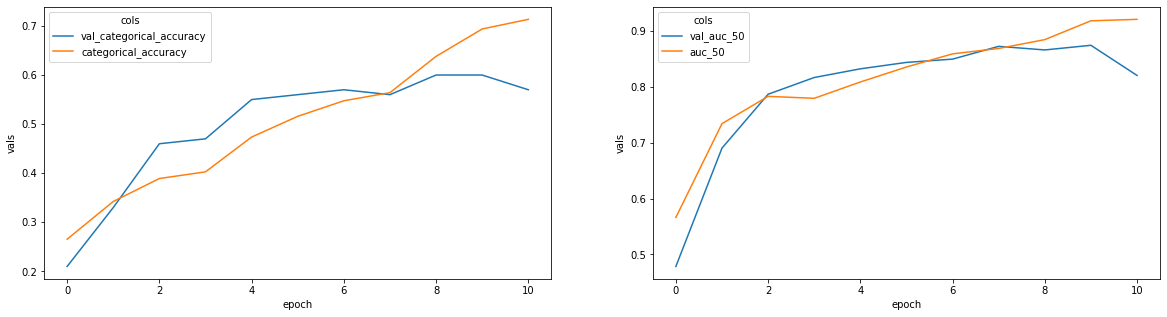

In [57]:
plt.rcParams["figure.figsize"] = (20,5)
fig, ax =plt.subplots(1,2)

df = pd.DataFrame.from_dict(storage_final)

search_auc_val_reg = re.compile('^.+auc_.*$')            
search_auc_val_key = list(filter(search_auc_val_reg.match, storage_final[0].keys()))

search_auc_reg = re.compile('^auc_.*$')            
search_auc_key = list(filter(search_auc_reg.match, storage_final[0].keys()))

categoical_analysis = df.loc[:,['val_categorical_accuracy', 
                                'categorical_accuracy', 'epoch']].melt('epoch', var_name='cols', value_name='vals')

val_analysis = df.loc[:,[search_auc_val_key[0], 
                              search_auc_key[0]  , 'epoch']].melt('epoch', var_name='cols', value_name='vals')

loss_analysis = df.loc[:,['loss', 'val_loss','epoch']].melt('epoch', var_name='cols', value_name='vals')


sns.lineplot(data=categoical_analysis, x='epoch', y='vals', hue='cols', ax=ax[0])
sns.lineplot(data=val_analysis, x='epoch', y='vals', hue='cols', ax=ax[1])
# sns.lineplot(data=loss_analysis, x='epoch', y='vals', hue='cols', ax=ax[1, 0])

display(df.sort_values('val_categorical_accuracy', axis=0, ascending=False))


Hence , as shown above , epoch 6 performs best with validation auc 0.91 and and validation val_categorical_accuracy 0.73. Running it multiple times has also provided result with 0.76 accuracy . The total trainable params are  348,485 . We could have added more layers and dense networks for better accuracy , but the number of parameters would have increases which would have contradicted our requirement of keeping it minimum. 

Decreasing layers any further (or decreasing the params leads to acc going below 0.60).